In [8]:
from mlp_mixer import * 
import json

####### EVAL PARAMS
one_batch = False

path = "./models/20220314-162951/"
path = "./models/20220319-183030/"
with open(path+'params.json') as json_file:
    params = json.load(json_file)

print(params)

image_width_height = params['image_width_and_height'] #da cambiare a seconda della dimensione dell'immagine
patch_dims = params['patch_width_and_height']
# variable_name = value #paper value
n_channels = params['hidden_dim_size (n_channels)'] #10 #512
num_layers = params['number_of_layers'] #3
mlp_dc_dimension = params['mlp_dc_dimension'] #8 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = params['mlp_ds_dimension'] #8 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension)

#model.load_state_dict(torch.load(path+"final.pth"))
model.load_state_dict(torch.load(path+"checkpoint_epch_20.pth"))
model.eval()


{'dataset': './cifar100_data', 'comment': 'added weight decay', 'train_size': 140, 'validation_size': 60, 'learning_rate': 0.001, 'epochs': 500, 'steps': 140, 'batch_size': 250, 'image_width_and_height': 32, 'patch_width_and_height': 4, 'hidden_dim_size (n_channels)': 32, 'number_of_layers': 5, 'mlp_dc_dimension': 128, 'mlp_ds_dimension': 32}


MLP_mixer(
  (patch_embedder): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4))
  (mixerlayers): ModuleList(
    (0): MixerLayer(
      (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (MLP1): MLP(
        (linear_gelu_stack): Sequential(
          (0): Linear(in_features=64, out_features=32, bias=True)
          (1): GELU()
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
      (MLP2): MLP(
        (linear_gelu_stack): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU()
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
    )
    (1): MixerLayer(
      (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (MLP1): MLP(
        (linear_gelu_stack): Sequential(
          (0): Linear

In [9]:
import torchvision
import torchvision.transforms as transforms


root = './cifar100_data' #if not in lab


pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization
test_dataset = torchvision.datasets.CIFAR100(root=root, train=False, transform=pad_totensor_transform)

if one_batch: 
    batch_size=len(test_dataset)
else:
    batch_size = params['batch_size']

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
from sklearn.metrics import accuracy_score


def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted.cpu(), dim=1)
    return accuracy_score(predicted, true_labels.cpu()) #forse questi passaggi a cpu non sono molto efficienti..

In [31]:
from tqdm.notebook import tqdm
import time
#import statistics

loss_func = loss_func = nn.CrossEntropyLoss()

#processor warmup
print("Processor warmup..")
for _ in enumerate(tqdm(test_loader)): #numero esempi/batchsize TODO check
    images = images.to(device)
    labels = labels.to(device)
    for _ in range(5):
        predicted = model(images)
print("..warmed up!")

if device == 'cuda':
    torch.cuda.synchronize()

times = list()

with torch.no_grad():
        model.eval()
        val_accuracy = 0
        temp = 0
        for i, (images, labels) in enumerate(tqdm(test_loader)): #numero esempi/batchsize TODO check
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            start = time.time()
            predicted = model(images)
            end = time.time()
            elapsed = end - start

            times.append(elapsed)
            val_accuracy += get_accuracy(predicted, labels)
        #print(f"Lenght val loader: {len(val_loader)}, counter: {temp}")
        val_accuracy /= len(test_loader) 
        print(f"Accuracy: {val_accuracy}")
        if one_batch:
            print(f"Elapsed: {elapsed}")
        times = np.array(times)
        mean_time = times.mean()
        print(f"Average time = {times.mean()}")

Processor warmup..


  0%|          | 0/40 [00:00<?, ?it/s]

..warmed up!


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 0.2953
Average time = 0.09576225280761719


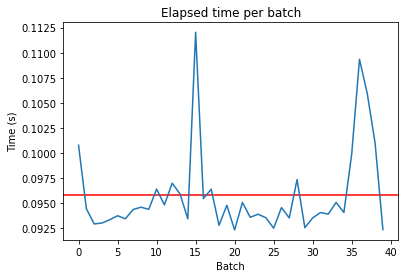

Average time per image: 0.38304901123046875ms


In [33]:
from matplotlib import pyplot as plt
import numpy as np

plt.axhline(y=mean_time, color='r', linestyle='-')
plt.plot(np.array(times))

plt.title("Elapsed time per batch")
plt.xlabel("Batch")
plt.ylabel("Time (s)")
plt.show()

print(f"Average time per image: {(mean_time/batch_size)*1000}ms")

In [34]:
len(times)

40